
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [7]:
# Load all CSV and Excel files
external_files = {
    "Crude Oil": r"C:\Users\gunas\Downloads\Coal-Price-Forecast-main\Coal-Price-Forecast-main\gas_price_data\Crude Oil WTI Futures Historical Data.csv",
    "Brent Oil": r"C:\Users\gunas\Downloads\Coal-Price-Forecast-main\Coal-Price-Forecast-main\gas_price_data\Brent Oil Futures Historical Data.csv",
    "Dubai Crude": r"C:\Users\gunas\Downloads\Coal-Price-Forecast-main\Coal-Price-Forecast-main\gas_price_data\Dubai Crude Oil (Platts) Financial Futures Historical Data.csv",
    "Dutch TTF": r"C:\Users\gunas\Downloads\Coal-Price-Forecast-main\Coal-Price-Forecast-main\gas_price_data\Dutch TTF Natural Gas Futures Historical Data.csv",
    "Natural Gas": r"C:\Users\gunas\Downloads\Coal-Price-Forecast-main\Coal-Price-Forecast-main\gas_price_data\Natural Gas Futures Historical Data.csv"
}

coal_file = r"C:\Users\gunas\Downloads\Coal-Price-Forecast-main\Coal-Price-Forecast-main\gas_price_data\coal_price_data.xlsx"

In [12]:
# Load coal price data
coal_df = pd.read_excel(coal_file, sheet_name=None)
coal_data = pd.concat(coal_df.values(), ignore_index=True)
coal_data['Date'] = pd.to_datetime(coal_data['Date'])
coal_data.sort_values(by='Date', inplace=True)

In [13]:
# Load and merge external factor data
external_data = []
for key, file in external_files.items():
    df = pd.read_csv(file, usecols=['Date', 'Price'])
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Price': key + '_Price'}, inplace=True)
    df.sort_values(by='Date', inplace=True)
    external_data.append(df)

merged_df = coal_data
for df in external_data:
    merged_df = pd.merge(merged_df, df, on='Date', how='left')

C:\Users\gunas\AppData\Local\Temp\ipykernel_27284\2281246549.py:5: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\gunas\AppData\Local\Temp\ipykernel_27284\2281246549.py:5: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\gunas\AppData\Local\Temp\ipykernel_27284\2281246549.py:5: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [14]:
# Fill missing values
merged_df.fillna(method='ffill', inplace=True)
merged_df.interpolate(method='linear', inplace=True)

C:\Users\gunas\AppData\Local\Temp\ipykernel_27284\1309235370.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)


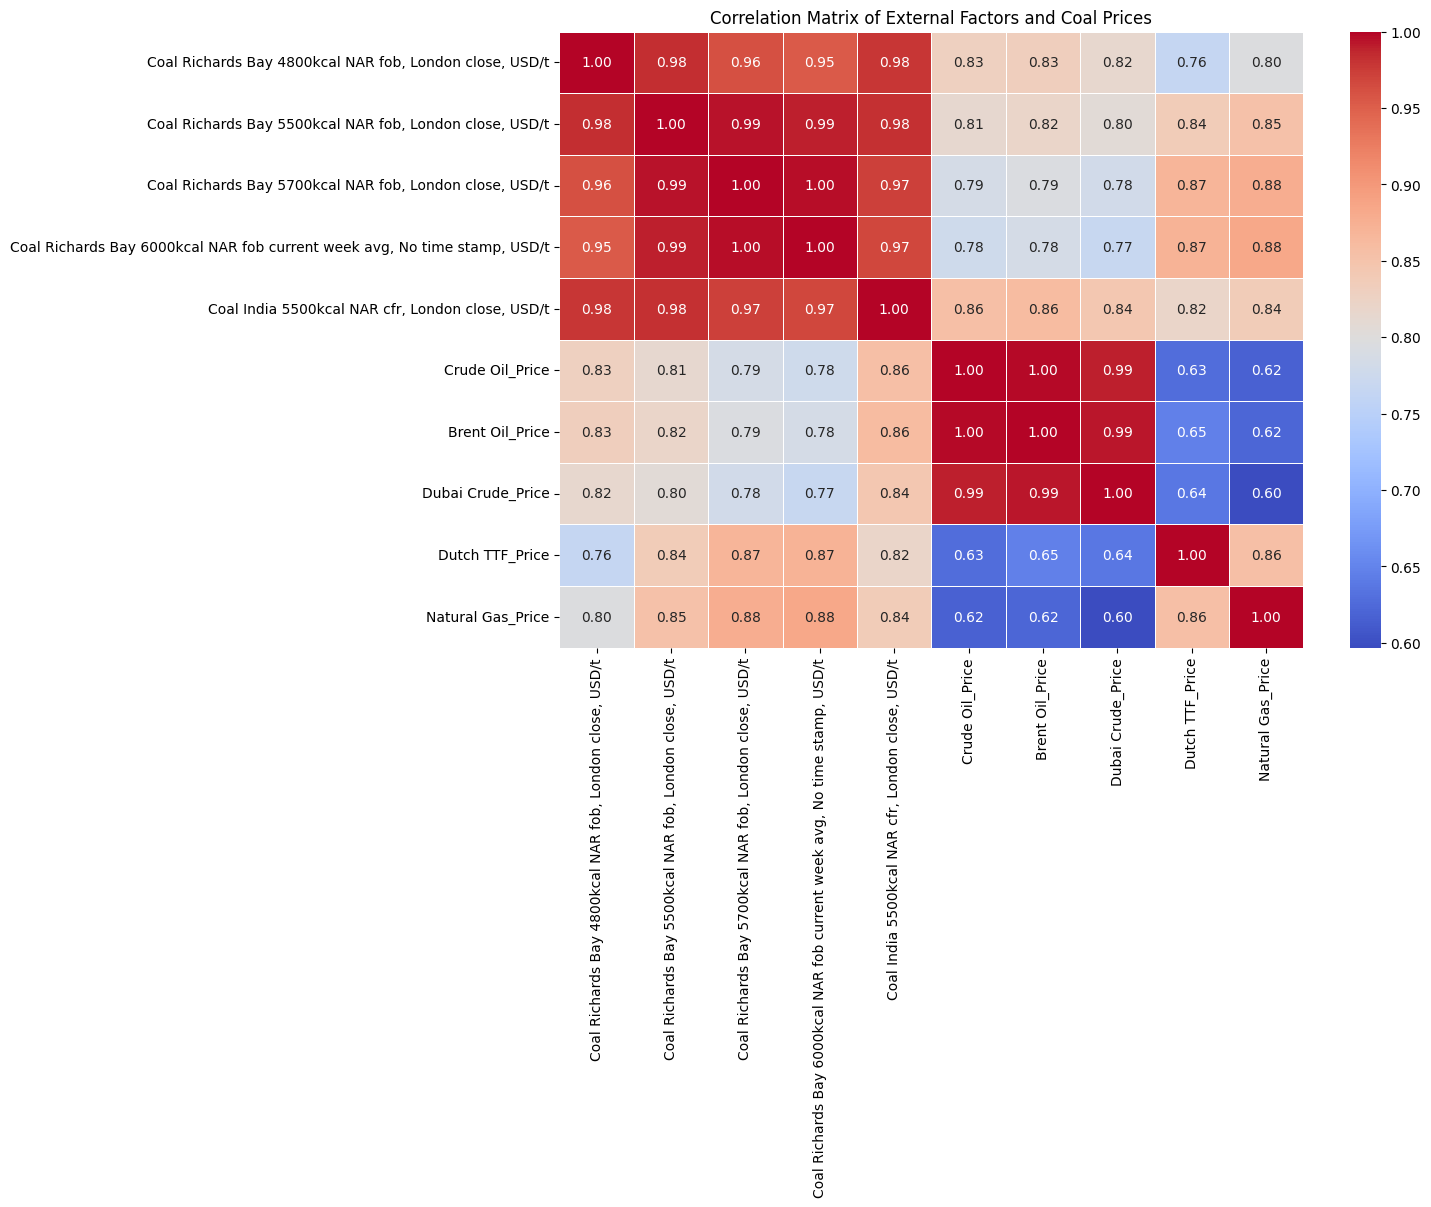

In [15]:
# Correlation matrix
correlation_matrix = merged_df.drop(columns=['Date']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of External Factors and Coal Prices")
plt.show()

In [16]:
# Define features and targets
feature_columns = ["Crude Oil_Price", "Brent Oil_Price", "Dubai Crude_Price", "Dutch TTF_Price", "Natural Gas_Price"]
target_columns = [col for col in merged_df.columns if col not in ['Date'] + feature_columns]
X = merged_df[feature_columns]
y = merged_df[target_columns]

In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:

# Hyperparameter tuning
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=3, random_state=42, n_jobs=-1)
search.fit(X_train, y_train)

,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [10, 20, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,n_iter,10
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [19]:
# Multi-output training
model = MultiOutputRegressor(search.best_estimator_)
model.fit(X_train, y_train)

,estimator,RandomForestR...ndom_state=42)
,n_jobs,None
,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


In [20]:
# Predictions
y_pred = model.predict(X_test)

In [21]:
# Evaluation
results = []
for idx, col in enumerate(target_columns):
    results.append({
        "Coal Type": col,
        "MAE": mean_absolute_error(y_test[col], y_pred[:, idx]),
        "RMSE": np.sqrt(mean_squared_error(y_test[col], y_pred[:, idx])),
        "R2": r2_score(y_test[col], y_pred[:, idx])
    })
results_df = pd.DataFrame(results)
print(results_df)

                                           Coal Type       MAE       RMSE  \
0  Coal Richards Bay 4800kcal NAR fob, London clo...  5.113725  11.469587   
1  Coal Richards Bay 5500kcal NAR fob, London clo...  5.924099  12.859862   
2  Coal Richards Bay 5700kcal NAR fob, London clo...  7.126309  14.695271   
3  Coal Richards Bay 6000kcal NAR fob current wee...  7.794949  14.927304   
4   Coal India 5500kcal NAR cfr, London close, USD/t  4.242791   8.197842   

         R2  
0  0.948606  
1  0.962319  
2  0.966732  
3  0.970098  
4  0.980403  


In [22]:
# Compute average R2 and save model + score
avg_r2_score = results_df["R2"].mean()
print(f"\nAverage R² Score: {avg_r2_score:.4f}")


Average R² Score: 0.9656


In [23]:
# Save both model and accuracy
joblib.dump({"model": model, "r2_score": avg_r2_score}, "coal_price_prediction.pkl")

['coal_price_prediction.pkl']

In [24]:

# Forecast future values (next 30 days)
future_dates = pd.date_range(start=merged_df['Date'].max() + pd.Timedelta(days=1), periods=30)
latest_external_factors = X.iloc[-1:].copy()
future_external_factors = []

for factor in feature_columns:
    model_fit = ExponentialSmoothing(X[factor], trend='add', seasonal=None).fit()
    forecast_values = model_fit.forecast(30)
    future_external_factors.append(forecast_values.values)

future_external_factors = pd.DataFrame(np.array(future_external_factors).T, columns=feature_columns)
future_predictions = model.predict(future_external_factors)
future_df = pd.DataFrame(future_predictions, columns=target_columns)
future_df['Date'] = future_dates

In [26]:
# Save predictions
future_df.to_csv("Coal_Price_Predictions.csv", index=False)

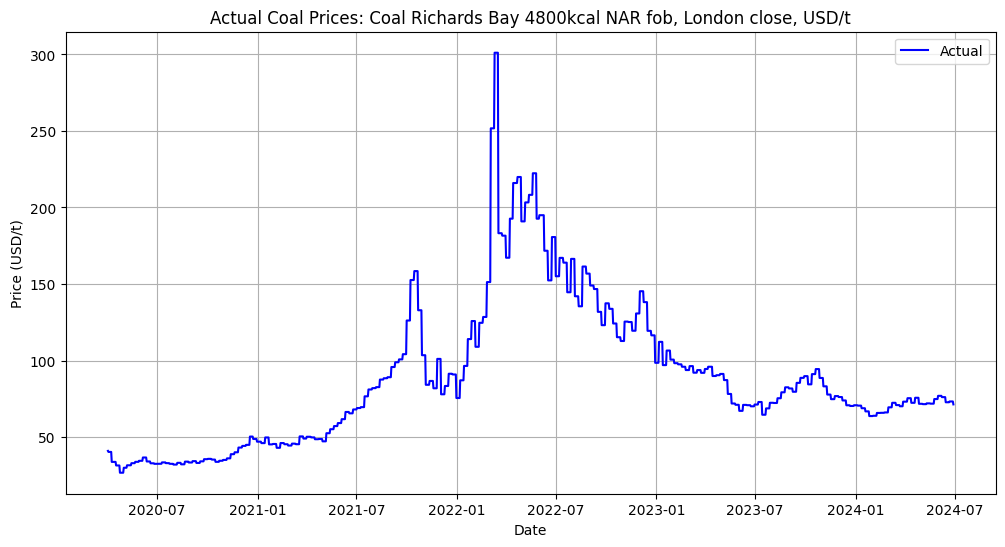

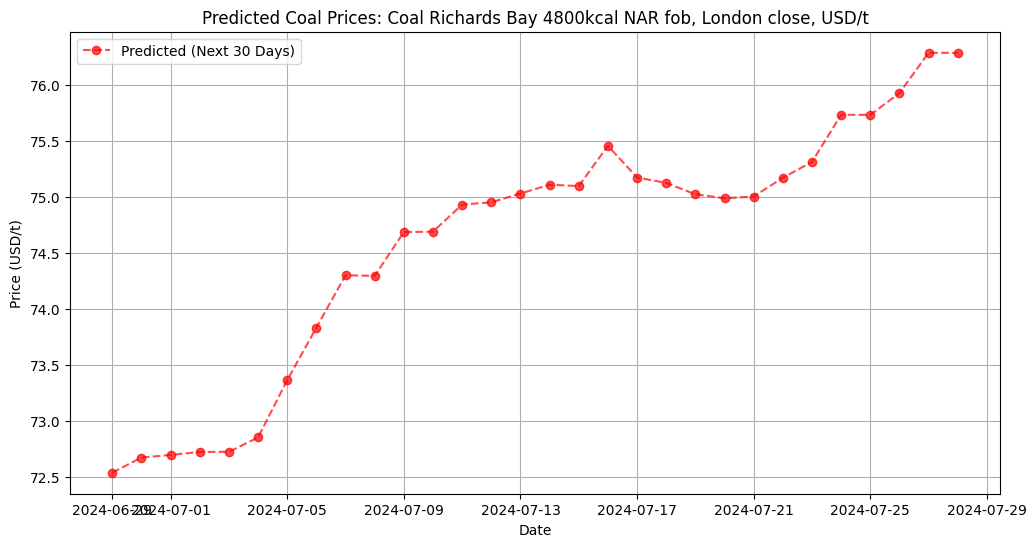

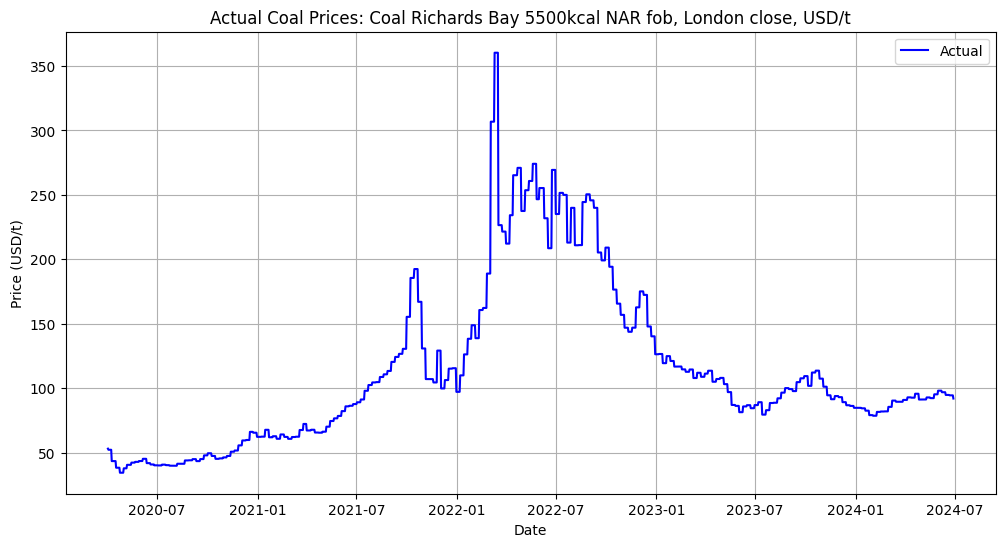

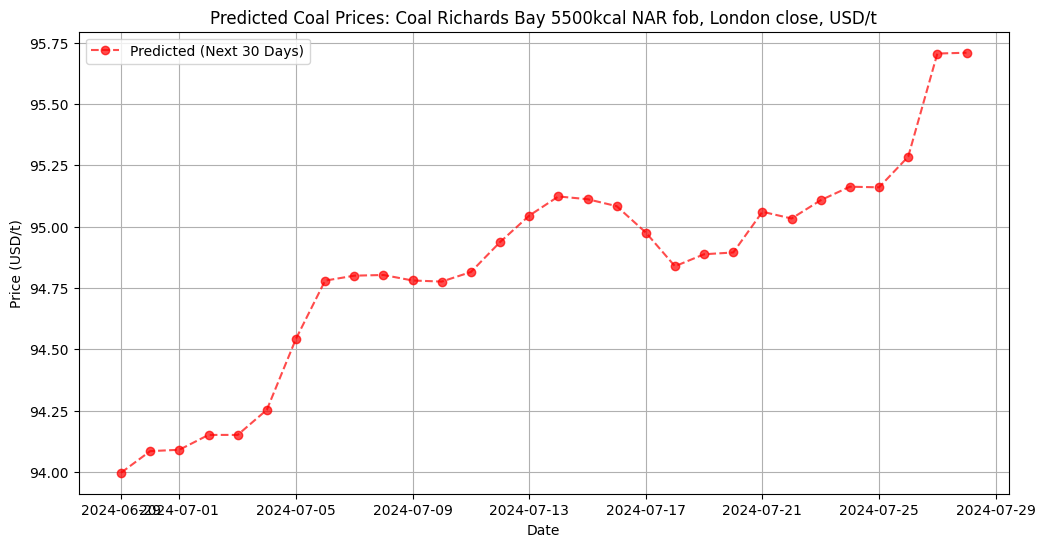

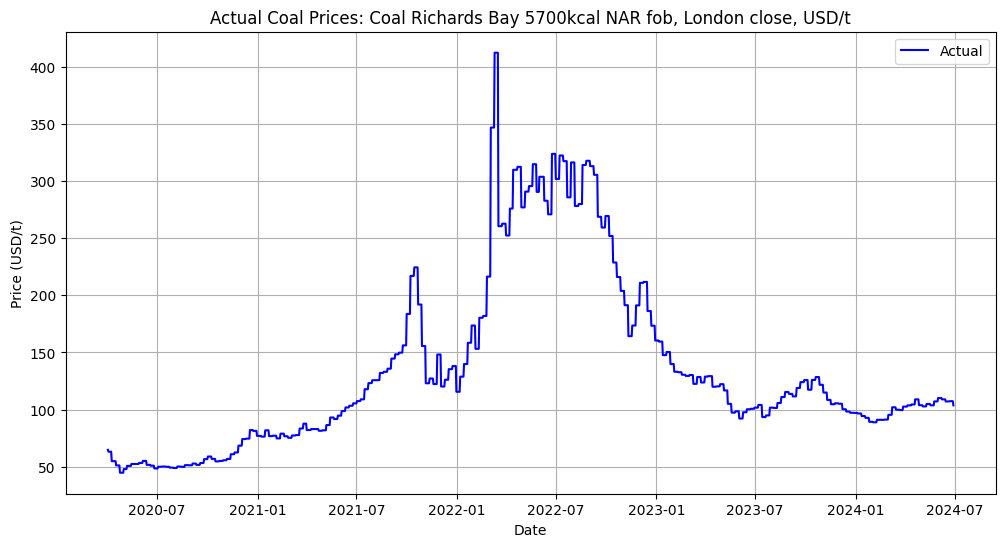

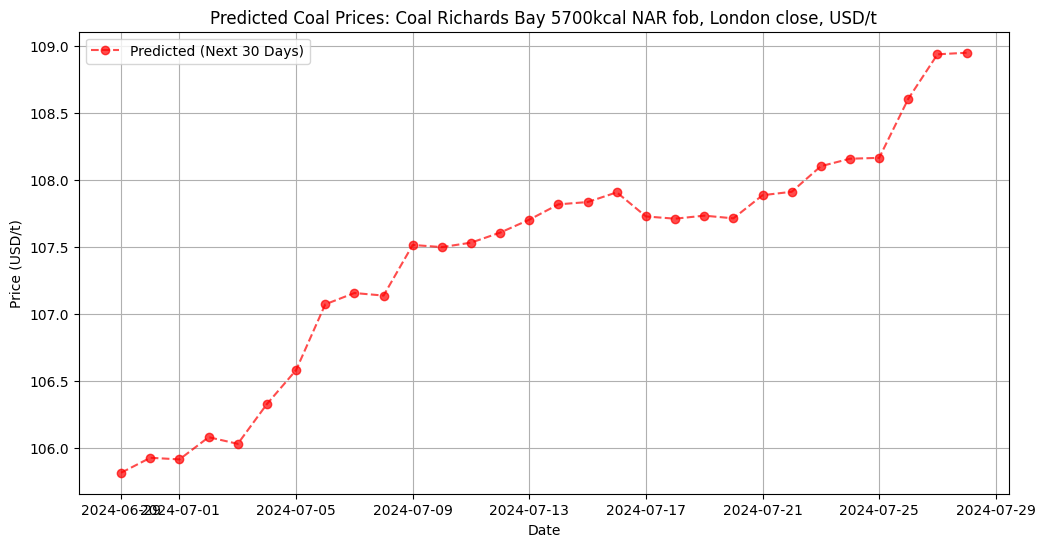

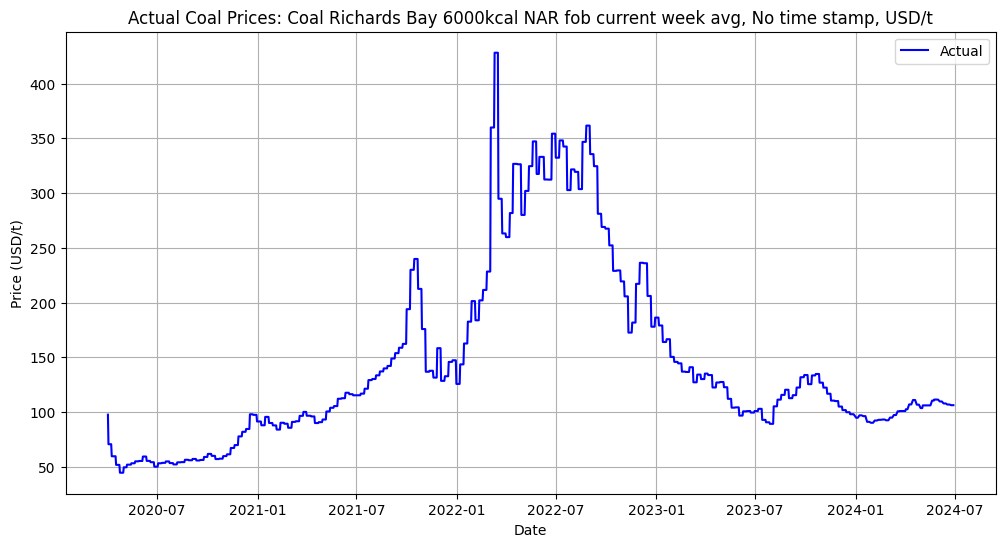

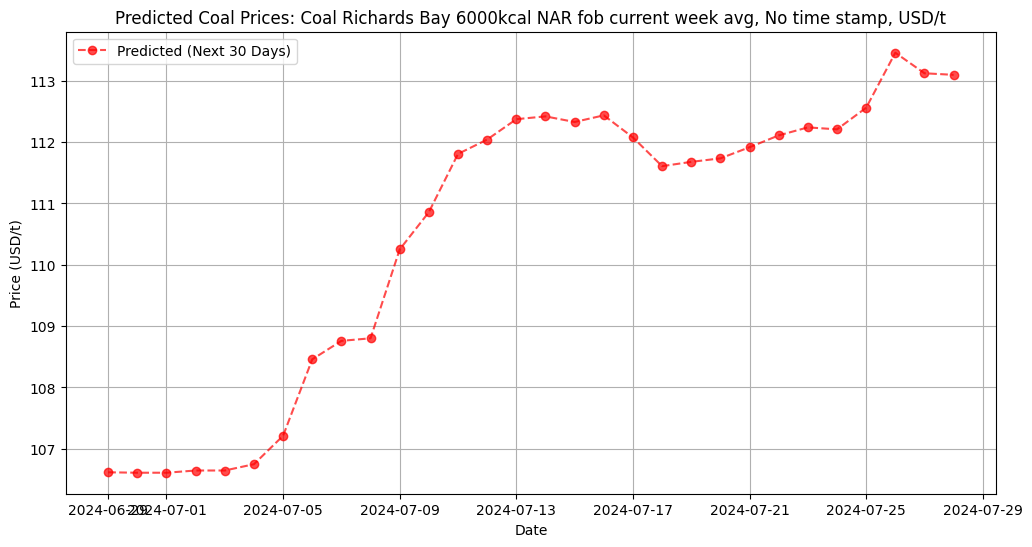

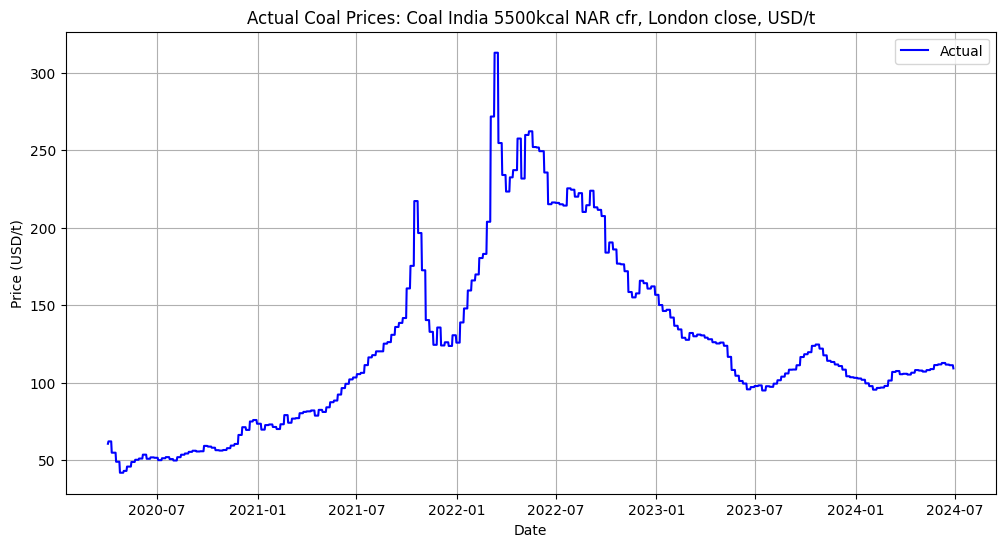

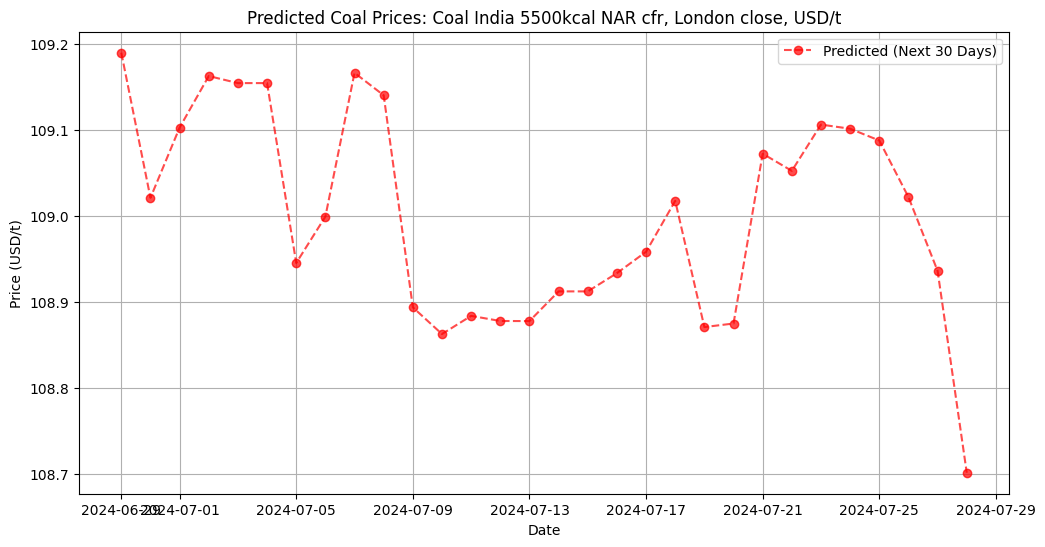


Predicted Coal Prices for the Next 30 Days:
    Coal Richards Bay 4800kcal NAR fob, London close, USD/t  \
0                                           72.539700         
1                                           72.675367         
2                                           72.698000         
3                                           72.725100         
4                                           72.726367         
5                                           72.854300         
6                                           73.365733         
7                                           73.835100         
8                                           74.301433         
9                                           74.296633         
10                                          74.687133         
11                                          74.690967         
12                                          74.932433         
13                                          74.952767         
14        

In [27]:


# Plot actual vs predicted
for col in target_columns:
    plt.figure(figsize=(12, 6))
    plt.plot(merged_df['Date'], merged_df[col], label='Actual', color='blue')
    plt.xlabel("Date")
    plt.ylabel("Price (USD/t)")
    plt.title(f"Actual Coal Prices: {col}")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(future_df['Date'], future_df[col], label='Predicted (Next 30 Days)', color='red', linestyle='dashed', marker='o', markersize=6, alpha=0.7)
    plt.xlabel("Date")
    plt.ylabel("Price (USD/t)")
    plt.title(f"Predicted Coal Prices: {col}")
    plt.legend()
    plt.grid(True)
    plt.show()

print("\nPredicted Coal Prices for the Next 30 Days:")
print(future_df)